In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tensorflow-gpu==2.2.0

     |████████████████████████████████| 516.2MB 32kB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.test.gpu_device_name()



'/device:GPU:0'

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
########################################
np.random.seed(27)
tf.random.set_seed(27)
tf.compat.v1.reset_default_graph()
BATCH_SIZE = 1000
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0, 
    verbose=1,
    patience=20,
    mode="auto",
    restore_best_weights=True)
#########################################
def plot_metrics(history):
  metrics =  ['mae','mse']
  plt.figure(figsize=(10,4))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").upper()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color="b", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="r", linestyle="--", label='Validation')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend(loc="best")
    plt.tight_layout()
  plt.show()

In [5]:
# load data  
# split train and test
from sklearn.model_selection import train_test_split
obsid_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_obsid.npy')
spectra_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_spectra.npy')
obsid_teff_logg = np.genfromtxt('/content/drive/My Drive/CNN_spectra_data/dr5_SNR100_obsid_teff_logg.csv'\
                                 ,delimiter=",")
print("data loaded")
num_spectra = len(obsid_teff_logg)
spectra_NN = np.zeros((num_spectra,len(spectra_all[0])))
for i in range(num_spectra):
  index = np.where(obsid_all == int(obsid_teff_logg[i][0]))
  spectra_NN[i] = spectra_all[index]
print("data matched")
spectra_train, spectra_val_test, teff_logg_train, teff_logg_val_test = train_test_split(spectra_NN,
                                                    obsid_teff_logg[:,1:],
                                                    test_size = 0.2,
                                                    random_state = 27)
#train samples
x_train = np.expand_dims(spectra_train,axis=2)
x_val_test = np.expand_dims(spectra_val_test,axis=2)
teff_train = teff_logg_train[:,0]
logg_train = teff_logg_train[:,1]

#validation
val_amount = int(len(x_val_test)/4)
x_val = x_val_test[:val_amount]
teff_logg_val = teff_logg_val_test[:val_amount]

#test
x_test = x_val_test[val_amount:]
teff_logg_test = teff_logg_val_test[val_amount:]

"""
#oversampling 
for i in range(len(x_train)):
    if teff_train < 5779.18333333 or teff_train >7138.75666667 :
        np.concatenate((x_train,x_train[i]), axis = 0)
        np.concatenate
"""
print("data part done")


print(len(x_train))
print(len(x_val))
print(len(x_test))

data loaded
data matched
data part done
24653
1541
4623


In [6]:
tf.compat.v1.reset_default_graph()
model_teff = tf.keras.Sequential()
model_teff.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_teff.add(tf.keras.layers.Conv1D(filters=16,kernel_size=8,padding="valid",activation="relu"))
model_teff.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_teff.add(tf.keras.layers.BatchNormalization(axis=-1))
model_teff.add(tf.keras.layers.Conv1D(filters=32,kernel_size=4,padding="valid",activation="relu"))
model_teff.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_teff.add(tf.keras.layers.BatchNormalization(axis=-1))
model_teff.add(tf.keras.layers.Conv1D(filters=64,kernel_size=4,padding="valid",activation="relu"))
model_teff.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_teff.add(tf.keras.layers.Flatten())
#model_teff.add(tf.keras.layers.BatchNormalization(axis=-1))
#model_teff.add(tf.keras.layers.Dense(2048,activation="relu"))
#model_teff.add(tf.keras.layers.Dropout(0.2))
model_teff.add(tf.keras.layers.BatchNormalization(axis=-1))
model_teff.add(tf.keras.layers.Dense(1024,activation="relu"))
model_teff.add(tf.keras.layers.Dropout(0.2))
model_teff.add(tf.keras.layers.Dense(1)) # represent output layer neurons 
model_teff.summary()
model_teff.compile(loss=tf.keras.losses.Huber(delta=1.5),
              optimizer='adam',
              metrics=['mae','mse'])
teff_init_weights = model_teff.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 4096, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 4089, 16)          144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1022, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1022, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1019, 32)          2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 32)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 254, 32)           1

Epoch 1/100
25/25 [==============================] - 2s 84ms/step - loss: 9050.2852 - mae: 6034.2734 - mse: 36955136.0000 - val_loss: 9524.7217 - val_mae: 6350.5645 - val_mse: 40678712.0000
Epoch 2/100
25/25 [==============================] - 2s 67ms/step - loss: 5572.0630 - mae: 3715.4573 - mse: 17047272.0000 - val_loss: 8582.2080 - val_mae: 5722.2222 - val_mse: 33181090.0000
Epoch 3/100
25/25 [==============================] - 2s 66ms/step - loss: 2400.0427 - mae: 1600.7787 - mse: 5361979.0000 - val_loss: 8967.6543 - val_mae: 5979.1855 - val_mse: 36166568.0000
Epoch 4/100
25/25 [==============================] - 2s 68ms/step - loss: 1485.0056 - mae: 990.7532 - mse: 2142450.5000 - val_loss: 7423.2505 - val_mae: 4949.5835 - val_mse: 25573240.0000
Epoch 5/100
25/25 [==============================] - 2s 67ms/step - loss: 725.9954 - mae: 484.7463 - mse: 483530.3125 - val_loss: 6020.7837 - val_mae: 4014.6062 - val_mse: 17500416.0000
Epoch 6/100
25/25 [==============================] - 2s 6

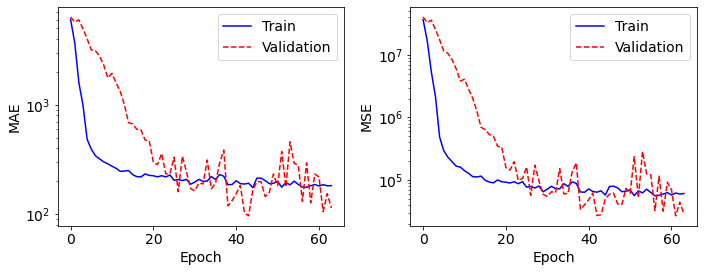

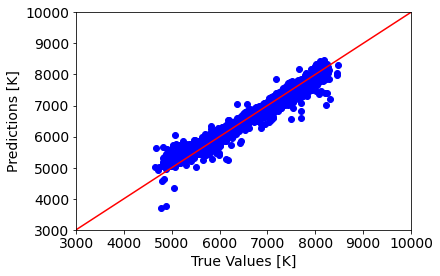

mean error of Teff=  -10.101085110284174
standard deviation of the Teff error =  134.0297724155572
1st order poly fit:  [  0.90806477 605.25008467]


In [7]:
model_teff.set_weights(teff_init_weights)
teff_hs = model_teff.fit(x_train, np.expand_dims(teff_logg_train[:,0],axis=1),
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val,np.expand_dims(teff_logg_val[:,0],axis=1)))

tf.saved_model.save( model_teff, "/content/drive/My Drive/CNN_models/Teff_model")
plot_metrics(teff_hs)

teff_predictions = model_teff.predict(x_test).flatten()
plt.figure()
plt.scatter(teff_logg_test[:,0], teff_predictions,color='b')
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
teff_lims = [3000, 10000]
plt.xlim(teff_lims)
plt.ylim(teff_lims)
_ = plt.plot(teff_lims, teff_lims,color = 'r')
plt.show()
teff_error = teff_logg_test[:,0]-teff_predictions
print("mean error of Teff= ", np.mean(teff_error))
print("standard deviation of the Teff error = ", np.std(teff_error))
print("1st order poly fit: ",np.polyfit(teff_logg_test[:,0], teff_predictions,deg=1))

np.save('/content/drive/My Drive/CNN_prediction/Teff_predict.npy', np.vstack([teff_logg_test[:,0], teff_predictions]))

In [8]:
np.polyfit(teff_logg_test[:,0], teff_predictions,deg=1)

array([  0.90806477, 605.25008467])

In [9]:
model_logg = tf.keras.Sequential()
model_logg.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_logg.add(tf.keras.layers.Conv1D(filters=16,kernel_size=8,padding="valid",activation="relu"))
model_logg.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_logg.add(tf.keras.layers.BatchNormalization(axis=-1))
model_logg.add(tf.keras.layers.Conv1D(filters=32,kernel_size=4,padding="valid",activation="relu"))
model_logg.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_logg.add(tf.keras.layers.BatchNormalization(axis=-1))
model_logg.add(tf.keras.layers.Conv1D(filters=64,kernel_size=4,padding="valid",activation="relu"))
model_logg.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_logg.add(tf.keras.layers.Flatten())
#model_logg.add(tf.keras.layers.BatchNormalization(axis=-1))
#model_logg.add(tf.keras.layers.Dense(2048,activation="relu"))
#model_logg.add(tf.keras.layers.Dropout(0.2))
model_logg.add(tf.keras.layers.BatchNormalization(axis=-1))
model_logg.add(tf.keras.layers.Dense(1024,activation="relu"))
model_logg.add(tf.keras.layers.Dropout(0.2))
model_logg.add(tf.keras.layers.Dense(1)) # represent output layer neurons 
model_logg.summary()
model_logg.compile(loss=tf.keras.losses.Huber(delta=1.5),
              optimizer='adam',
              metrics=['mae','mse'])
logg_init_weights = model_logg.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 4096, 1)           4         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4089, 16)          144       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1022, 16)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1022, 16)          64        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1019, 32)          2080      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 254, 32)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 254, 32)          

Epoch 1/100
25/25 [==============================] - 2s 73ms/step - loss: 4.7241 - mae: 3.8148 - mse: 30.7193 - val_loss: 4.7874 - val_mae: 3.9416 - val_mse: 15.8462
Epoch 2/100
25/25 [==============================] - 2s 67ms/step - loss: 0.9272 - mae: 1.1493 - mse: 3.1717 - val_loss: 3.8340 - val_mae: 3.3058 - val_mse: 11.1564
Epoch 3/100
25/25 [==============================] - 2s 66ms/step - loss: 0.6898 - mae: 0.9316 - mse: 2.3865 - val_loss: 4.0564 - val_mae: 3.4527 - val_mse: 12.1146
Epoch 4/100
25/25 [==============================] - 2s 66ms/step - loss: 1.0110 - mae: 1.2296 - mse: 2.9666 - val_loss: 2.4096 - val_mae: 2.3529 - val_mse: 5.7104
Epoch 5/100
25/25 [==============================] - 2s 66ms/step - loss: 0.4438 - mae: 0.7421 - mse: 1.2159 - val_loss: 2.2784 - val_mae: 2.2652 - val_mse: 5.2333
Epoch 6/100
25/25 [==============================] - 2s 66ms/step - loss: 0.2954 - mae: 0.5981 - mse: 0.7269 - val_loss: 1.5948 - val_mae: 1.8048 - val_mse: 3.3551
Epoch 7/100


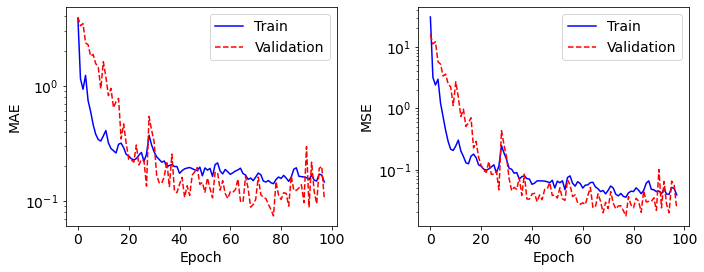

INFO:tensorflow:Assets written to: /content/drive/My Drive/CNN_models/logg_model/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/CNN_models/logg_model/assets


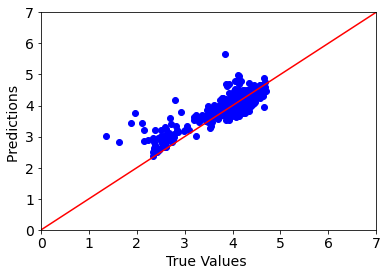

mean error of log(g)=  -0.004194994047454961
standard deviation of the log(g)error =  0.15082407394051367
1st order poly fit: [0.69331968 1.25777173]


In [10]:
model_logg.set_weights(logg_init_weights)
logg_hs = model_logg.fit(x_train, np.expand_dims(teff_logg_train[:,1],axis=1),
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val,np.expand_dims(teff_logg_val[:,1],axis=1)))
plot_metrics(logg_hs)
model_logg.save("/content/drive/My Drive/CNN_models/logg_model")
tf.saved_model.save( model_logg, "/content/drive/My Drive/CNN_models/logg_model")

logg_predictions = model_logg.predict(x_test).flatten()
plt.figure()
plt.scatter(teff_logg_test[:,1], logg_predictions, color='b')
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
logg_lims = [0, 7]
plt.xlim(logg_lims)
plt.ylim(logg_lims)
_ = plt.plot(logg_lims, logg_lims, color='r')
plt.show()

logg_error = teff_logg_test[:,1]-logg_predictions
print("mean error of log(g)= ", np.mean(logg_error))
print("standard deviation of the log(g)error = ", np.std(logg_error))
print("1st order poly fit:", np.polyfit(teff_logg_test[:,1], logg_predictions,deg = 1))


np.save('/content/drive/My Drive/CNN_prediction/logg_predict.npy', np.vstack([teff_logg_test[:,1], logg_predictions]))

In [16]:
def evaluate(predict):
    print("RMSE = ",np.sqrt(np.mean((predict[0]-predict[1])**2)))
evaluate(np.vstack([teff_logg_test[:,1], logg_predictions]))

RMSE =  0.1508824020721824
